In [3]:
import pandas as pd
import numpy as np
import keras
import tensorflow


In [2]:
IMG_SIZE = 224
FRAMES = 18

# ` 1 - Create a custom data loader `

In [5]:
import numpy as np
from keras.utils import Sequence
import os


class NpyDataGenerator(Sequence):
    def __init__(self, directory, batch_size=32, shuffle=True, num_classes=100):
        self.directory = directory
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_classes = num_classes

        # Create a list of tuples containing the file paths and labels for each file
        self.data = []
        for label in os.listdir(self.directory):
            label_dir = os.path.join(self.directory, label)
            for file in os.listdir(label_dir):
                file_path = os.path.join(label_dir, file)
                self.data.append((file_path, int(label)-71))

        # Shuffle the list of tuples if shuffle is True
        if self.shuffle:
            np.random.shuffle(self.data)

    def __len__(self):
        return int(np.ceil(len(self.data) / float(self.batch_size)))

    def __getitem__(self, idx):
        # Get the file paths and labels for the current batch
        batch_data = self.data[idx *
                               self.batch_size:(idx + 1) * self.batch_size]
        file_paths, labels = zip(*batch_data)

        # Load the data for each file in the batch and convert the labels to categorical format
        data = [np.load(file_path) for file_path in file_paths]
        labels = keras.utils.to_categorical(labels, self.num_classes)

        return np.array(data), np.array(labels)


### 1.a - To merge sequences and train the model on simultaneously on them, we created a custom sequence to merge two sequences

In [6]:
import numpy as np
from keras.utils import Sequence


class MergedSequence(Sequence):
    def __init__(self, sequence_1, sequence_2, batch_size=32):
        self.sequence_1 = sequence_1
        self.sequence_2 = sequence_2
        self.batch_size = batch_size

    def __len__(self):
        # Return the length of the longer sequence
        return max(len(self.sequence_1), len(self.sequence_2))

    def __getitem__(self, idx):
        # Get the data from the first sequence
        data_1, labels_1 = self.sequence_1[idx]
        data_2, labels_2 = self.sequence_2[idx]
        return np.concatenate((data_1, data_2), axis=0), np.concatenate((labels_1, labels_2), axis=0)


In [7]:
import numpy as np
from keras.utils import Sequence


class MultiSequence(Sequence):
    def __init__(self, sequences, batch_size=32):
        self.sequences = sequences
        self.batch_size = batch_size

    def __len__(self):
        # Return the length of the longest sequence
        return max(len(seq) for seq in self.sequences)

    def __getitem__(self, idx):
        # Get the data from all sequences
        data = []
        labels = []
        for seq in self.sequences:
            try:
                data.append(seq[idx][0])
                labels.append(seq[idx][1])
            except Exception:
                # If the index is out of bounds for a sequence, just skip it
                pass
        return np.concatenate(data, axis=0), np.concatenate(labels, axis=0)


# ` 2 - Model building `

In [8]:

import tensorflow as tf
from keras.layers import Embedding, Input, Dense, LSTM, Flatten, LayerNormalization, Dropout
from keras_nlp.layers import TransformerEncoder, PositionEmbedding
from keras import layers

def initialize_model():
    input_layer = Input(shape=(FRAMES, 2048))
    reg = Dense(512, activation='relu')(input_layer)
    embedding = PositionEmbedding(sequence_length=FRAMES)(reg)
    t_encoder_output = TransformerEncoder(intermediate_dim=128, num_heads=64)(embedding)
    concatenated = keras.layers.concatenate([input_layer, t_encoder_output])
    reduced = layers.GlobalMaxPooling1D()(concatenated)
    normalized = LayerNormalization()(reduced)
    drop = Dropout(0.7)(normalized)
    output_layer = Dense(100, activation='softmax')(drop)
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model



# ` 4 - Training `

## `a. Signer dependent`

 ### `1 -> 1`

In [62]:
import matplotlib.pyplot as plt

train = NpyDataGenerator(
    '../data/01_hand/train', batch_size=32, shuffle=True, num_classes=100)
validation = NpyDataGenerator( '../data/01_hand/validation', batch_size=32, shuffle=True, num_classes=100)

FileNotFoundError: [Errno 2] No such file or directory: '../data/01_hand/train'

In [ ]:


model = initialize_model()
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train, epochs= 30, validation_data=validation)
plt.plot(history.history['loss'])

Epoch 1/20
91/91 [==============================] - 5s 43ms/step - loss: 6.8502 - accuracy: 0.0138 - val_loss: 4.0744 - val_accuracy: 0.1298 - lr: 0.0010
Epoch 2/20
91/91 [==============================] - 2s 26ms/step - loss: 5.0056 - accuracy: 0.0596 - val_loss: 3.0561 - val_accuracy: 0.4693 - lr: 0.0011
Epoch 3/20
91/91 [==============================] - 3s 29ms/step - loss: 3.3175 - accuracy: 0.2144 - val_loss: 2.0421 - val_accuracy: 0.6719 - lr: 0.0013
Epoch 4/20
91/91 [==============================] - 3s 28ms/step - loss: 2.0241 - accuracy: 0.4926 - val_loss: 0.9732 - val_accuracy: 0.8930 - lr: 0.0014
Epoch 5/20
91/91 [==============================] - 3s 29ms/step - loss: 0.9874 - accuracy: 0.7477 - val_loss: 0.4879 - val_accuracy: 0.8930 - lr: 0.0016
Epoch 6/20
91/91 [==============================] - 4s 40ms/step - loss: 0.6139 - accuracy: 0.8128 - val_loss: 0.2235 - val_accuracy: 0.9529 - lr: 0.0018
Epoch 7/20
91/91 [==============================] - 2s 27ms/step - loss: 0.4

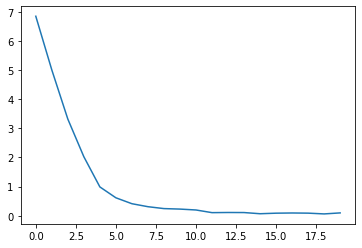

In [249]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint('../models/01_on_01.h5', monitor='val_loss', save_best_only=True)
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch / 20))
model = initialize_model()
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train, epochs= 20, validation_data=validation, callbacks=[early_stopping, checkpoint, lr_schedule])
plt.plot(history.history['loss'])

In [250]:
test = NpyDataGenerator('../data/01_hand/test', batch_size=32, shuffle=True, num_classes=100)
model.evaluate(test)

113/113 [==============================] - 4s 32ms/step - loss: 0.3542 - accuracy: 0.9323


[0.3541734516620636, 0.9322598576545715]

### `2 -> 2`

In [251]:
import matplotlib.pyplot as plt

train = NpyDataGenerator(
    '../data/02_hand/train', batch_size=32, shuffle=True, num_classes=100)
validation = NpyDataGenerator( '../data/02_hand/validation', batch_size=32, shuffle=True, num_classes=100)

Epoch 1/30
91/91 [==============================] - 27s 281ms/step - loss: 6.7302 - accuracy: 0.0145 - val_loss: 4.1983 - val_accuracy: 0.0471 - lr: 0.0010
Epoch 2/30
91/91 [==============================] - 3s 27ms/step - loss: 5.0993 - accuracy: 0.0576 - val_loss: 3.2686 - val_accuracy: 0.2268 - lr: 0.0011
Epoch 3/30
91/91 [==============================] - 2s 25ms/step - loss: 3.5106 - accuracy: 0.1889 - val_loss: 2.3965 - val_accuracy: 0.5706 - lr: 0.0013
Epoch 4/30
91/91 [==============================] - 2s 25ms/step - loss: 2.2751 - accuracy: 0.4505 - val_loss: 1.4458 - val_accuracy: 0.7261 - lr: 0.0014
Epoch 5/30
91/91 [==============================] - 2s 25ms/step - loss: 1.3335 - accuracy: 0.6605 - val_loss: 0.5690 - val_accuracy: 0.9116 - lr: 0.0016
Epoch 6/30
91/91 [==============================] - 2s 25ms/step - loss: 0.7519 - accuracy: 0.7901 - val_loss: 0.2773 - val_accuracy: 0.9472 - lr: 0.0018
Epoch 7/30
91/91 [==============================] - 2s 25ms/step - loss: 0

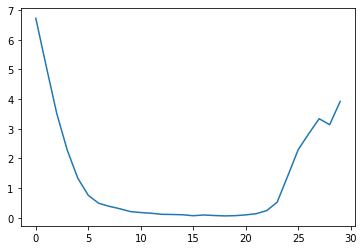

In [252]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint('../models/02_on_02.h5', monitor='val_loss', save_best_only=True)
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch / 20))

model = initialize_model()
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train, epochs= 30, validation_data=validation, callbacks=[early_stopping, checkpoint, lr_schedule])
plt.plot(history.history['loss'])

In [253]:
test = NpyDataGenerator('../data/02_hand/test', batch_size=32, shuffle=True, num_classes=100)
model.evaluate(test)

113/113 [==============================] - 3s 30ms/step - loss: 2.7301 - accuracy: 0.9289


[2.7301065921783447, 0.9289283752441406]

### `3 -> 3`

Epoch 1/30
91/91 [==============================] - 16s 160ms/step - loss: 6.7155 - accuracy: 0.0179 - val_loss: 4.2075 - val_accuracy: 0.0713 - lr: 0.0010
Epoch 2/30
91/91 [==============================] - 4s 39ms/step - loss: 4.9320 - accuracy: 0.0586 - val_loss: 3.0673 - val_accuracy: 0.4536 - lr: 0.0011
Epoch 3/30
91/91 [==============================] - 3s 28ms/step - loss: 3.2856 - accuracy: 0.2234 - val_loss: 2.0202 - val_accuracy: 0.7247 - lr: 0.0013
Epoch 4/30
91/91 [==============================] - 2s 26ms/step - loss: 1.9307 - accuracy: 0.5319 - val_loss: 1.0547 - val_accuracy: 0.8302 - lr: 0.0014
Epoch 5/30
91/91 [==============================] - 2s 26ms/step - loss: 1.0266 - accuracy: 0.7342 - val_loss: 0.3486 - val_accuracy: 0.9558 - lr: 0.0016
Epoch 6/30
91/91 [==============================] - 2s 26ms/step - loss: 0.5742 - accuracy: 0.8345 - val_loss: 0.2195 - val_accuracy: 0.9458 - lr: 0.0018
Epoch 7/30
91/91 [==============================] - 2s 26ms/step - loss: 0

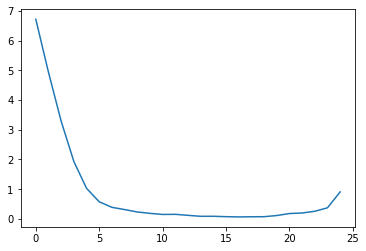

In [254]:
train = NpyDataGenerator(
    '../data/03_hand/train', batch_size=32, shuffle=True, num_classes=100)
validation = NpyDataGenerator( '../data/03_hand/validation', batch_size=32, shuffle=True, num_classes=100)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint('../models/03_on_03.h5', monitor='val_loss', save_best_only=True)
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch / 20))

model = initialize_model()
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train, epochs= 30, validation_data=validation, callbacks=[early_stopping, checkpoint, lr_schedule])
plt.plot(history.history['loss'])

In [255]:
test = NpyDataGenerator('../data/03_hand/test', batch_size=32, shuffle=True, num_classes=100)
model.evaluate(test)

113/113 [==============================] - 8s 71ms/step - loss: 0.0367 - accuracy: 0.9900


[0.036682091653347015, 0.9900055527687073]

## ` b. Signer independent `

### `03 + 02 -> 01`

In [256]:
import matplotlib.pyplot as plt

train_02 = NpyDataGenerator(
    '../data/02_hand/train', batch_size=32, shuffle=True, num_classes=100)
train_03 = NpyDataGenerator(
    '../data/03_hand/train', batch_size=32, shuffle=True, num_classes=100)
val_02 = NpyDataGenerator(
    '../data/02_hand/validation', batch_size=32, shuffle=True, num_classes=100)
val_03 = NpyDataGenerator(
    '../data/03_hand/validation', batch_size=32, shuffle=True, num_classes=100)

validation = NpyDataGenerator( '../data/01_hand/validation', batch_size=32, shuffle=True, num_classes=100)

merged = MultiSequence([train_02, train_03, val_02, val_03], batch_size=32)

Epoch 1/30
91/91 [==============================] - 11s 111ms/step - loss: 6.2624 - accuracy: 0.0196 - val_loss: 4.0461 - val_accuracy: 0.0699 - lr: 0.0010
Epoch 2/30
91/91 [==============================] - 10s 105ms/step - loss: 4.0554 - accuracy: 0.1088 - val_loss: 3.2013 - val_accuracy: 0.3210 - lr: 0.0011
Epoch 3/30
91/91 [==============================] - 9s 94ms/step - loss: 2.6551 - accuracy: 0.3454 - val_loss: 2.4243 - val_accuracy: 0.4907 - lr: 0.0013
Epoch 4/30
91/91 [==============================] - 10s 110ms/step - loss: 1.7058 - accuracy: 0.5453 - val_loss: 1.9577 - val_accuracy: 0.5078 - lr: 0.0014
Epoch 5/30
91/91 [==============================] - 8s 88ms/step - loss: 1.0501 - accuracy: 0.7050 - val_loss: 1.7897 - val_accuracy: 0.5934 - lr: 0.0016
Epoch 6/30
91/91 [==============================] - 10s 114ms/step - loss: 0.7281 - accuracy: 0.7818 - val_loss: 1.8164 - val_accuracy: 0.5563 - lr: 0.0018
Epoch 7/30
91/91 [==============================] - 8s 87ms/step - l

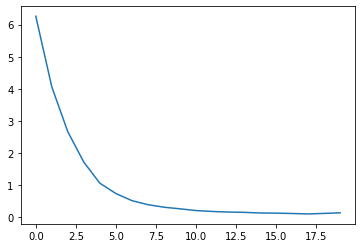

In [257]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint('../models/02+03_on_01.h5', monitor='val_loss', save_best_only=True)
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch / 20))

model = initialize_model()
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(merged, epochs= 30, validation_data=validation, callbacks=[early_stopping, checkpoint, lr_schedule])
plt.plot(history.history['loss'])

In [258]:
test = NpyDataGenerator('../data/01_hand/test', batch_size=32, shuffle=True, num_classes=100)
model.evaluate(test)

113/113 [==============================] - 3s 30ms/step - loss: 2.0991 - accuracy: 0.6385


[2.0990641117095947, 0.6385341286659241]

### ` 03 + 01 -> 02`

In [259]:
import matplotlib.pyplot as plt

train_03 = NpyDataGenerator(
    '../data/03_hand/train', batch_size=32, shuffle=True, num_classes=100)
train_01 = NpyDataGenerator(
    '../data/01_hand/train', batch_size=32, shuffle=True, num_classes=100)
val_03 = NpyDataGenerator(
    '../data/03_hand/validation', batch_size=32, shuffle=True, num_classes=100)
val_01 = NpyDataGenerator(
    '../data/01_hand/validation', batch_size=32, shuffle=True, num_classes=100)

validation = NpyDataGenerator( '../data/02_hand/validation', batch_size=32, shuffle=True, num_classes=100)

merged = MultiSequence([train_01, train_03, val_01, val_03], batch_size=32)

Epoch 1/30
91/91 [==============================] - 29s 308ms/step - loss: 6.3236 - accuracy: 0.0167 - val_loss: 4.0326 - val_accuracy: 0.0984 - lr: 0.0010
Epoch 2/30
91/91 [==============================] - 10s 113ms/step - loss: 4.0041 - accuracy: 0.1187 - val_loss: 3.2379 - val_accuracy: 0.3352 - lr: 0.0011
Epoch 3/30
91/91 [==============================] - 11s 116ms/step - loss: 2.6104 - accuracy: 0.3558 - val_loss: 2.5394 - val_accuracy: 0.3652 - lr: 0.0013
Epoch 4/30
91/91 [==============================] - 9s 101ms/step - loss: 1.6316 - accuracy: 0.5647 - val_loss: 1.9835 - val_accuracy: 0.4936 - lr: 0.0014
Epoch 5/30
91/91 [==============================] - 10s 110ms/step - loss: 0.9893 - accuracy: 0.7163 - val_loss: 1.8217 - val_accuracy: 0.5435 - lr: 0.0016
Epoch 6/30
91/91 [==============================] - 11s 120ms/step - loss: 0.6588 - accuracy: 0.8014 - val_loss: 1.8588 - val_accuracy: 0.5364 - lr: 0.0018
Epoch 7/30
91/91 [==============================] - 10s 108ms/ste

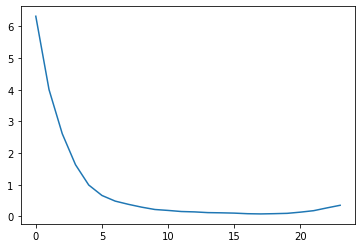

In [260]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint('../models/02+03_on_01.h5', monitor='val_loss', save_best_only=True)
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch / 20))

model = initialize_model()
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(merged, epochs= 30, validation_data=validation, callbacks=[early_stopping, checkpoint, lr_schedule])
plt.plot(history.history['loss'])

In [261]:
test = NpyDataGenerator('../data/02_hand/test', batch_size=32, shuffle=True, num_classes=100)
model.evaluate(test)

113/113 [==============================] - 4s 35ms/step - loss: 1.8721 - accuracy: 0.6094


[1.872089147567749, 0.6093837022781372]

### ` 02 + 01 -> 03`

In [262]:
import matplotlib.pyplot as plt

train_02 = NpyDataGenerator(
    '../data/02_hand/train', batch_size=32, shuffle=True, num_classes=100)
train_01 = NpyDataGenerator(
    '../data/01_hand/train', batch_size=32, shuffle=True, num_classes=100)
val_02 = NpyDataGenerator(
    '../data/02_hand/validation', batch_size=32, shuffle=True, num_classes=100)
val_01 = NpyDataGenerator(
    '../data/01_hand/validation', batch_size=32, shuffle=True, num_classes=100)

validation = NpyDataGenerator( '../data/03_hand/validation', batch_size=32, shuffle=True, num_classes=100)

merged = MultiSequence([train_01, train_02, val_01, val_02], batch_size=32)

Epoch 1/30
91/91 [==============================] - 13s 122ms/step - loss: 6.2910 - accuracy: 0.0176 - val_loss: 4.0125 - val_accuracy: 0.1498 - lr: 0.0010
Epoch 2/30
91/91 [==============================] - 8s 88ms/step - loss: 4.0428 - accuracy: 0.1144 - val_loss: 3.2301 - val_accuracy: 0.2796 - lr: 0.0011
Epoch 3/30
91/91 [==============================] - 9s 98ms/step - loss: 2.6667 - accuracy: 0.3538 - val_loss: 2.3751 - val_accuracy: 0.4793 - lr: 0.0013
Epoch 4/30
91/91 [==============================] - 9s 104ms/step - loss: 1.6760 - accuracy: 0.5600 - val_loss: 1.8722 - val_accuracy: 0.4936 - lr: 0.0014
Epoch 5/30
91/91 [==============================] - 8s 88ms/step - loss: 1.0330 - accuracy: 0.7100 - val_loss: 1.6711 - val_accuracy: 0.5492 - lr: 0.0016
Epoch 6/30
91/91 [==============================] - 8s 89ms/step - loss: 0.7100 - accuracy: 0.7903 - val_loss: 1.5949 - val_accuracy: 0.5792 - lr: 0.0018
Epoch 7/30
91/91 [==============================] - 10s 114ms/step - loss

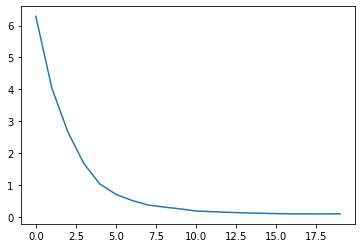

In [263]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint('../models/02+03_on_01.h5', monitor='val_loss', save_best_only=True)
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch / 20))

model = initialize_model()
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(merged, epochs= 30, validation_data=validation, callbacks=[early_stopping, checkpoint, lr_schedule])
plt.plot(history.history['loss'])

In [264]:
test = NpyDataGenerator('../data/03_hand/test', batch_size=32, shuffle=True, num_classes=100)
model.evaluate(test)

113/113 [==============================] - 3s 29ms/step - loss: 1.5612 - accuracy: 0.6044


[1.561241626739502, 0.6043864488601685]

# ` Conculsion `

### Signer dependent 
| Signer |  Accuracy |
| --- |  --- |
| 01 | 93.2% |
| 02 | 92.9% |
| 03 | 99.0% |

### Signer independent
| Signer |  Accuracy |
| --- |  --- |
| 01 ( trained on 02, 03) | 63.9% |
| 02 ( trained on 01, 03) | 60.9% |
| 03 ( trained on 01, 02) | 60.4% |


# `Inference`

In [9]:
model = initialize_model()
model.load_weights('../models/02+03_on_01.h5')

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



/opt/miniconda3/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [10]:
from keras import applications
import cv2
import mediapipe as mp


def build_feature_extractor():
    InceptionV3_model = applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3), )

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocess_input = keras.applications.inception_v3.preprocess_input(inputs)
    outputs = InceptionV3_model(preprocess_input)
    myModel = keras.Model(inputs, outputs, name="feature_extractor")
    return myModel


feature_extractor = build_feature_extractor()

objc[10141]: Class CaptureDelegate is implemented in both /opt/miniconda3/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x29be0e538) and /opt/miniconda3/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_videoio.3.4.16.dylib (0x29e030860). One of the two will be used. Which one is undefined.
objc[10141]: Class CVWindow is implemented in both /opt/miniconda3/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x29be0e588) and /opt/miniconda3/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x298000a68). One of the two will be used. Which one is undefined.
objc[10141]: Class CVView is implemented in both /opt/miniconda3/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x29be0e5b0) and /opt/miniconda3/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x298000a90). One of the two will be used. Which one is undefined.
objc[10141]: Class CVSlider is implemented in both /opt/miniconda3/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x29be0e5d8) 

In [11]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

def detect_hand(img):
    img_copy = np.zeros(img.shape)
    results = hands.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    spec = mp_drawing.DrawingSpec(thickness=0, circle_radius=0)
    spec2 = mp_drawing.DrawingSpec(color = (161,61,45))
    if results.multi_hand_landmarks:
        for hand_no, hand_landmarks in enumerate(results.multi_hand_landmarks):
            mp_drawing.draw_landmarks(image = img_copy, landmark_list = hand_landmarks,
                                      connections = mp_hands.HAND_CONNECTIONS, landmark_drawing_spec = spec,
                                      connection_drawing_spec = spec2)
    return img_copy

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [13]:
labels = pd.read_excel('../data/KARSL-100_Labels.xlsx', index_col=0)
labels

,Sign-Arabic,Sign-English
SignID,,
71,هيكل عظمي,Skeleton
72,جمجة,skull
73,عمود فقري,Backbone
74,قفص صدري,Chest
75,جهاز تنفسي,Respiratory device
...,...,...
166,يشم,inhale
167,يصعد,rise
168,ينزل,descend


In [14]:
import re 
import imageio
from IPython.display import Image

def load_video(path, images):
    match = re.search(r'\d{4}', path)
    if match:
        label = match.group()
    frames = []
    for file in os.listdir(path):
        if file.endswith(".jpg"):
            img = cv2.imread(os.path.join(path, file))
            images.append(img)
            frames.append(cv2.resize(detect_hand(img), (IMG_SIZE, IMG_SIZE)))
    return np.array(frames)/255, int(label)

def inference(model, frames):
    output = feature_extractor.predict(frames)
    output = np.expand_dims(output, axis=0)
    print(output.shape)
    predictions = model.predict(output)
    probs_sorted = np.sort(predictions[0])[::-1]
    args = np.argsort(predictions[0])[::-1]
    return {i:j for i,j in zip(args[:3], probs_sorted[:3])}  


In [20]:
images = []
# features, label = load_video('../data/01/train/0071/03_01_0071_(01_12_16_15_52_44)', images)
features, label = load_video('../data/03/test/0075/03_03_0075_(13_12_16_17_54_17)', images)

pred = inference(model, features)
pred = {labels.loc[i+71, 'Sign-English']:j for i,j in pred.items()}
actual = labels.loc[label, 'Sign-English']
random = np.random.randint(299494)
imageio.mimsave(f'../inference_gifs/{label}{random}.gif', images)
# pred, actual
print(f'Actual: {actual}')
print(f'Predicted: {pred}')
Image(url=f'../inference_gifs/{label}{random}.gif')

/opt/miniconda3/lib/python3.9/site-packages/google/protobuf/symbol_database.py:78: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 [==============================] - 0s 139ms/step
(1, 18, 2048)
1/1 [==============================] - 0s 35ms/step
Actual: Respiratory device
Predicted: {'Respiratory device': 0.98886746, 'laser ray': 0.0033606067, 'surgery': 0.0029914808}
